In [1]:
%matplotlib inline

from copy import deepcopy
from time import time
from collections import OrderedDict

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolplanck')

from halotools.utils import SampleSelector

hosts, subs = SampleSelector.host_halo_selection(table=halocat.halo_table, return_subhalos=True)

In [3]:
log10_msub_min = 11
subhalo_mpeak_cut = 10**log10_msub_min

log10_mhost_min = max(11.5, log10_msub_min)
log10_mhost_max = 14.75

subhalo_sample_mask = subs['halo_mpeak'] > subhalo_mpeak_cut
subhalo_sample_mask *= subs['halo_mvir_host_halo'] > 10**log10_mhost_min
host_halo_sample_mask = hosts['halo_mvir'] > 10**log10_mhost_min

num_mhost_bins = 25
haloprop_bins = np.logspace(log10_mhost_min, log10_mhost_max, num_mhost_bins)
log10_bin_mids = 0.5*(np.log10(haloprop_bins[:-1]) + np.log10(haloprop_bins[1:]))
bin_mids = 10**log10_bin_mids

from halotools.mock_observables import hod_from_mock

mean_occupation_bolshoi, bin_edges = hod_from_mock(subs['halo_mvir_host_halo'][subhalo_sample_mask], 
                                           hosts['halo_mvir'][host_halo_sample_mask], 
                                                   haloprop_bins)
host_halo_counts_bolshoi = np.histogram(hosts['halo_mvir'][host_halo_sample_mask], 
                                bins=haloprop_bins)[0].astype('f4')
subhalo_counts_bolshoi = np.histogram(subs['halo_mvir_host_halo'][subhalo_sample_mask], 
                                bins=haloprop_bins)[0].astype('f4')


In [4]:
from jiang_usmf import monte_carlo_subhalo_population, jiang14_param_dict

def subhalo_counts_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2):
    params = dict(beta=beta, zeta=zeta, gamma1=gamma1, alpha1=alpha1, 
                 gamma2=gamma2, alpha2=alpha2)
    mc_nsub, mc_subhalo_mpeak = monte_carlo_subhalo_population(hosts['halo_mvir'][host_halo_sample_mask], 
                                                           log10_msub_min, 
                                                           np.log10(haloprop_bins), **params)
    model_subs_mhost = np.repeat(hosts['halo_mvir'][host_halo_sample_mask], mc_nsub)
    return np.histogram(model_subs_mhost, 
                                bins=haloprop_bins)[0].astype('f4') 

def chi2_subhalo_counts(params):
    beta, zeta, gamma1, alpha1, gamma2, alpha2 = params
    
    num_mocks = 1
    chi2_arr = np.zeros(num_mocks)
    for i in range(num_mocks):
        subhalo_counts_model = subhalo_counts_prediction(beta, zeta, gamma1, alpha1, gamma2, alpha2)
        chi2_arr[i] = np.sum((subhalo_counts_model - subhalo_counts_bolshoi)**2/host_halo_counts_bolshoi)
    return np.mean(chi2_arr)


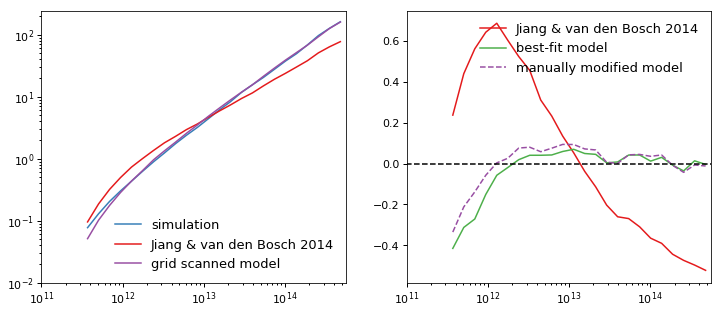

In [5]:
from jiang_usmf import read_best_fit_params

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

mean_occupation_model1 = subhalo_counts_prediction(*jiang14_param_dict.values())/host_halo_counts_bolshoi

best_fit_param_dict = read_best_fit_params('best_fit_param_dict.txt')
del best_fit_param_dict['chi2']

mean_occupation_model2 = subhalo_counts_prediction(*best_fit_param_dict.values())/host_halo_counts_bolshoi

modified_param_dict = deepcopy(best_fit_param_dict)
modified_param_dict['alpha2'] = 0.
modified_param_dict['beta'] = 4.25
modified_param_dict['zeta'] = 1.25
mean_occupation_model3 = subhalo_counts_prediction(*modified_param_dict.values())/host_halo_counts_bolshoi

__=ax1.loglog()
__=ax1.plot(bin_mids, mean_occupation_bolshoi, label='simulation', color=blue)
__=ax1.plot(bin_mids, mean_occupation_model1, label='Jiang & van den Bosch 2014', color=red)
# __=ax1.plot(bin_mids, mean_occupation_model2, label='manually fitted model', color=green)
__=ax1.plot(bin_mids, mean_occupation_model3, label='grid scanned model', color=purple)

xscale2 = ax2.set_xscale('log')
fracdiff1 = (mean_occupation_model1 - mean_occupation_bolshoi)/mean_occupation_bolshoi
fracdiff2 = (mean_occupation_model2 - mean_occupation_bolshoi)/mean_occupation_bolshoi
fracdiff3 = (mean_occupation_model3 - mean_occupation_bolshoi)/mean_occupation_bolshoi

__=ax2.plot(bin_mids, fracdiff1, label='Jiang & van den Bosch 2014', color=red)
__=ax2.plot(bin_mids, fracdiff2, label='best-fit model', color=green)
__=ax2.plot(bin_mids, fracdiff3, '--',label='manually modified model', color=purple)
__=ax2.plot(np.logspace(log10_mhost_min-1, log10_mhost_max+1, 100), np.zeros(100), '--', color='k')

xlim1 = ax1.set_xlim(xmin=10**(log10_mhost_min-0.5), xmax=10**log10_mhost_max)
xlim2 = ax2.set_xlim(xmin=10**(log10_mhost_min-0.5), xmax=10**log10_mhost_max)
ylim1 = ax1.set_ylim(ymin=0.01)


legend1 = ax1.legend()
legend2 = ax2.legend()

In [ ]:
best_fit_param_dict

In [6]:
host_halo_counts_bolshoi

array([  4.52140000e+04,   3.45550000e+04,   2.60390000e+04,
         1.95940000e+04,   1.50100000e+04,   1.16850000e+04,
         8.59600000e+03,   6.66100000e+03,   4.81100000e+03,
         3.73800000e+03,   2.74200000e+03,   2.05400000e+03,
         1.49100000e+03,   1.07300000e+03,   8.11000000e+02,
         5.70000000e+02,   4.15000000e+02,   2.67000000e+02,
         2.05000000e+02,   1.39000000e+02,   7.70000000e+01,
         5.60000000e+01,   3.10000000e+01,   1.90000000e+01], dtype=float32)